In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

In [0]:
#Import GDD and KDD data. Keep only GDD and KDD data
GDD_KDD = pd.read_csv('GDD_KDD_Cleaned.csv', index_col = 0)
GDD_KDD.index = pd.to_datetime(GDD_KDD.index)

GDD_KDD = GDD_KDD.drop(['TMAX_obs', 'TMIN_obs', 'TMAX_bound', 'TMIN_bound'], axis = 1)

In [0]:
#Import development data for Illinois

IL_Development = pd.read_csv('illinois_combined_development_data.csv', index_col = 0)
IL_Development.index = pd.to_datetime(IL_Development.index)

IL_Development = IL_Development.drop(['sum'], axis = 1)

In [0]:
#GDD are calculated for each county and development phase. For each day, multiply percent of crop in phase of interest by the GDD on that day.
#Since we only have one county, product of GDD and percent of crop in phase of interest is the GDD for that day

In [5]:
#Index for both dataframes needs to be identical. Currently they are not because we removed some "bad years" from the weather data due to holes
#Removed 1983, 1986, 1998, 1999, 2000, and 2016. There are 13514 days between (inclusive) 1981 - 2017. Removing these years there should be 11322 days.
#Rember about leap years!

print(len(IL_Development.index))
print(len(GDD_KDD.index))

#Join the dfs. GDD and KDD columns will have NaN for years that were removed in previous cleaning. Then drop rows with any NaN.
df = IL_Development.join(GDD_KDD)
df = df.dropna()

print(len(df.index))

df.head()

13514
11322
11322


,vegetative,early_grain,late_grain,GDD,KDD
1981-01-01,0.0,0.0,0.0,0.0,0.0
1981-01-02,0.0,0.0,0.0,0.0,0.0
1981-01-03,0.0,0.0,0.0,0.0,0.0
1981-01-04,0.0,0.0,0.0,0.0,0.0
1981-01-05,0.0,0.0,0.0,0.0,0.0


In [6]:
#Calculate GDDs and KDDs for phases. Phase data should be in percent format so divide phase columns by 100

phases = ['vegetative', 'early_grain', 'late_grain']

for p in phases:
  df[p] = df[p]/100

for p in phases:
  df['GDD_'+p] = df[p] * df['GDD']
  
for p in phases:
  df['KDD_'+p] = df[p] * df['KDD']
  
df.loc['2017-04-15':'2017-04-20']

,vegetative,early_grain,late_grain,GDD,KDD,GDD_vegetative,GDD_early_grain,GDD_late_grain,KDD_vegetative,KDD_early_grain,KDD_late_grain
2017-04-15,0.051429,0.0,0.0,8.20,0.0,0.421714,0.0,0.0,0.0,0.0,0.0
2017-04-16,0.060000,0.0,0.0,11.00,0.0,0.660000,0.0,0.0,0.0,0.0,0.0
2017-04-17,0.100000,0.0,0.0,6.35,0.0,0.635000,0.0,0.0,0.0,0.0,0.0
2017-04-18,0.140000,0.0,0.0,7.15,0.0,1.001000,0.0,0.0,0.0,0.0,0.0
2017-04-19,0.180000,0.0,0.0,7.70,0.0,1.386000,0.0,0.0,0.0,0.0,0.0
2017-04-20,0.220000,0.0,0.0,8.80,0.0,1.936000,0.0,0.0,0.0,0.0,0.0


In [7]:
df.loc['2017-04-15':'2017-04-20']['GDD_vegetative'].values

array([0.42171429, 0.66      , 0.635     , 1.001     , 1.386     ,
       1.936     ])

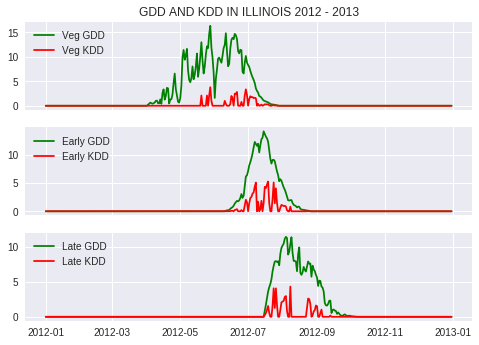

In [8]:
#Visualize GDD and KDD for vegetative phase
#Orientation from https://matplotlib.org/examples/pylab_examples/subplots_demo.html

x = df.loc['2012-01-01':'2012-12-31'].index
y1 = df.loc['2012-01-01':'2012-12-31']['GDD_vegetative'].values
y2 = df.loc['2012-01-01':'2012-12-31']['KDD_vegetative'].values
y3 = df.loc['2012-01-01':'2012-12-31']['GDD_early_grain'].values  
y4 = df.loc['2012-01-01':'2012-12-31']['KDD_early_grain'].values
y5 = df.loc['2012-01-01':'2012-12-31']['GDD_late_grain'].values 
y6 = df.loc['2012-01-01':'2012-12-31']['KDD_late_grain'].values  
  
  
f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(x, y1, color = 'green', label = 'Veg GDD')
axarr[0].plot(x, y2, color = 'red', label = 'Veg KDD')
axarr[0].legend(loc = 'upper left')
axarr[0].set_title('GDD AND KDD IN ILLINOIS 2012 - 2013')

axarr[1].plot(x, y3, color = 'green', label = 'Early GDD')
axarr[1].plot(x, y4, color = 'red', label = 'Early KDD')
axarr[1].legend(loc = 'upper left')

axarr[2].plot(x, y5, color = 'green', label = 'Late GDD')
axarr[2].plot(x, y6, color = 'red', label= 'Late KDD')
axarr[2].legend(loc = 'upper left')

In [0]:
#Find yearly average GDD/KDD for each phase.
data = {}
phase = ['GDD_vegetative', 'GDD_early_grain', 'GDD_late_grain', 'KDD_vegetative', 'KDD_early_grain', 'KDD_late_grain']

mean_development_df = pd.DataFrame()
mean_development_df['year'] = df.index.year.unique() #Make year column to eventually map dictionaries to

for p in phase: #Iterate through all phases
  for y in df.index.year.unique(): #Iterate through all years within each phase
    data[y] = df[p][(df.index.year == y)].mean() #Make a dictionary with key = year and values are the mean values in each phase for that year
    mean_development_df[p] = mean_development_df['year'].map(data) #Match dictionary key to column of years and put in values from dictionary
    
mean_development_df.head()

,year,GDD_vegetative,GDD_early_grain,GDD_late_grain,KDD_vegetative,KDD_early_grain,KDD_late_grain
0,1981,2.108359,0.823876,1.234161,0.095409,0.028719,0.031610
1,1982,2.237647,0.745351,1.224173,0.074162,0.063381,0.038842
2,1984,2.255080,0.742555,1.241253,0.187655,0.110284,0.183959
3,1985,2.201089,0.800572,1.433259,0.164840,0.079768,0.140930
4,1987,2.240381,0.831239,1.297272,0.265117,0.172497,0.241803


In [0]:
#Upload the yield data. Filter to Mercer County in IL.
df_yield = pd.read_csv('yield.csv')

df_yield = df_yield[(df_yield['county'] == 'MERCER') & (df_yield['year'] >= 1981) & (df_yield['state_fips'] == 17)]

print(df_yield.head())

print(df_yield.tail())

     year  state_fips  county  county_code  yield
185  2017          17  MERCER          131  238.7
186  2016          17  MERCER          131  213.5
187  2015          17  MERCER          131  205.7
188  2014          17  MERCER          131  193.5
189  2013          17  MERCER          131  177.1
     year  state_fips  county  county_code  yield
217  1985          17  MERCER          131  119.0
218  1984          17  MERCER          131  118.0
219  1983          17  MERCER          131   96.0
220  1982          17  MERCER          131  124.0
221  1981          17  MERCER          131  134.0


In [0]:
#Prepare to combine yield and yearly GDD and KDD data into one dataframe

#Remember that we removed some "bad" years from GDD and KDD data. Remove those same years from yield.
years = mean_development_df['year'].values
df_yield = df_yield[df_yield['year'].isin(years)]

#Check that the length of years is the same for both dataframes before appending
print(len(df_yield['year']) == len(mean_development_df['year']))

#Append on years column
mercer_county_df = pd.merge(df_yield, mean_development_df, how = 'left', on = ['year'])

#Reverse order so oldest is in row 1
#mercer_county_df = mercer_county_df.iloc[::-1]

mercer_county_df.head()

True


,year,state_fips,county,county_code,yield,GDD_vegetative,GDD_early_grain,GDD_late_grain,KDD_vegetative,KDD_early_grain,KDD_late_grain
0,2017,17,MERCER,131,238.7,2.071702,0.835070,1.359123,0.197761,0.087581,0.034912
1,2015,17,MERCER,131,205.7,2.101664,0.787372,1.280817,0.045532,0.056528,0.092917
2,2014,17,MERCER,131,193.5,2.008723,0.825788,1.351281,0.088535,0.019154,0.057263
3,2013,17,MERCER,131,177.1,2.099697,0.815136,1.383256,0.174577,0.076578,0.210273
4,2012,17,MERCER,131,180.1,1.916869,1.050954,1.092298,0.127064,0.203059,0.136278


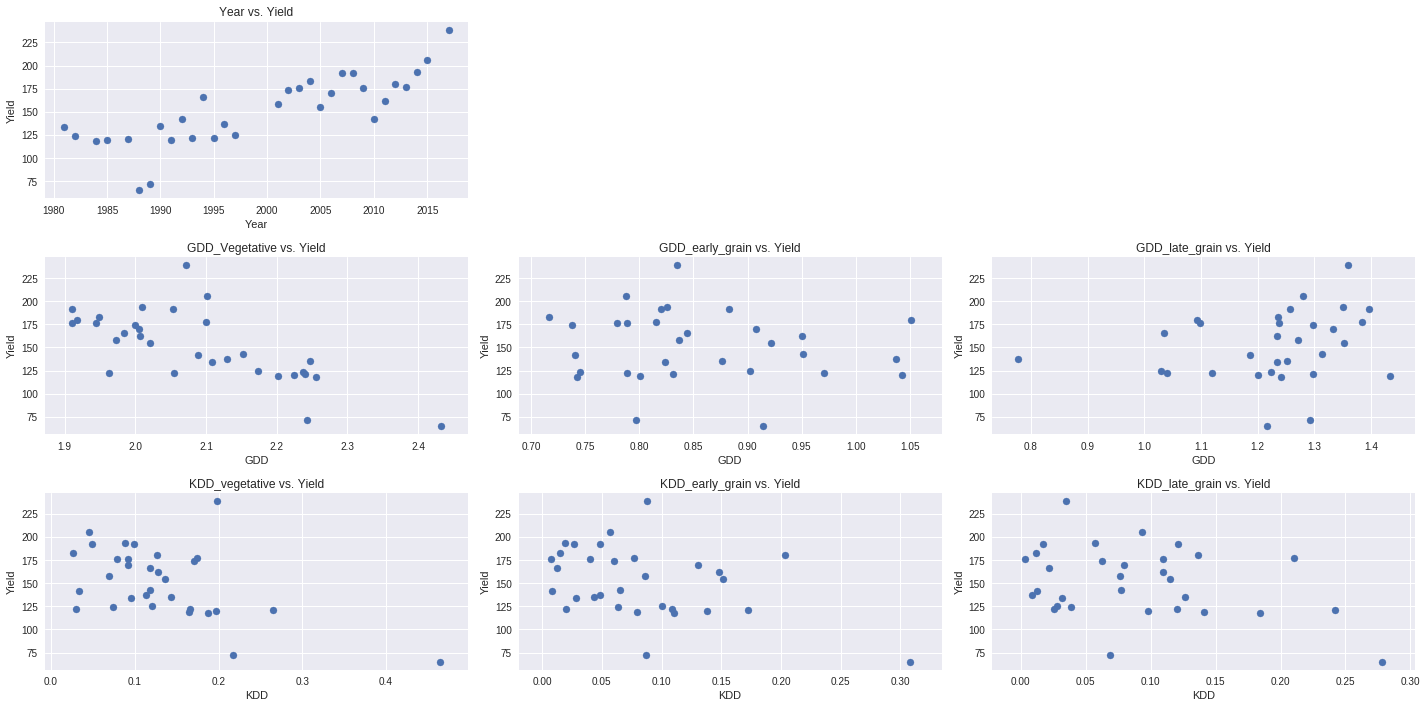

In [0]:
#Check for linearity in variables

f = plt.figure(figsize = (20,10))
ax = f.add_subplot(331)
ax2 = f.add_subplot(334)
ax3 = f.add_subplot(335)
ax4 = f.add_subplot(336)
ax5 = f.add_subplot(337)
ax6 = f.add_subplot(338)
ax7 = f.add_subplot(339)

ax.scatter(df['year'], y)
ax.set_xlabel('Year')
ax.set_ylabel('Yield')
ax.set_title('Year vs. Yield')

ax2.scatter(df['GDD_vegetative'], y)
ax2.set_xlabel('GDD')
ax2.set_ylabel('Yield')
ax2.set_title('GDD_Vegetative vs. Yield')

ax3.scatter(df['GDD_early_grain'], y)
ax3.set_xlabel('GDD')
ax3.set_ylabel('Yield')
ax3.set_title('GDD_early_grain vs. Yield')

ax4.scatter(df['GDD_late_grain'], y)
ax4.set_xlabel('GDD')
ax4.set_ylabel('Yield')
ax4.set_title('GDD_late_grain vs. Yield')

ax5.scatter(df['KDD_vegetative'], y)
ax5.set_xlabel('KDD')
ax5.set_ylabel('Yield')
ax5.set_title('KDD_vegetative vs. Yield')

ax6.scatter(df['KDD_early_grain'], y)
ax6.set_xlabel('KDD')
ax6.set_ylabel('Yield')
ax6.set_title('KDD_early_grain vs. Yield')

ax7.scatter(df['KDD_late_grain'], y)
ax7.set_xlabel('KDD')
ax7.set_ylabel('Yield')
ax7.set_title('KDD_late_grain vs. Yield')

plt.tight_layout()

In [0]:
from sklearn import linear_model

x = mercer_county_df[['year','GDD_vegetative', 'GDD_early_grain', 'GDD_late_grain', 'KDD_vegetative', 'KDD_early_grain', 'KDD_late_grain']]
y =mercer_county_df['yield']

regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 -4168.973910611118
Coefficients: 
 [  2.23218194 -64.4268627  -35.5435637   26.75925678 -15.68373374
 -94.79065752  -7.61154571]


In [0]:
mercer_county_df1 = mercer_county_df[['yield','year','GDD_vegetative', 'GDD_early_grain', 'GDD_late_grain', 'KDD_vegetative', 'KDD_early_grain', 'KDD_late_grain']]
mercer_county_df1.corr()

,yield,year,GDD_vegetative,GDD_early_grain,GDD_late_grain,KDD_vegetative,KDD_early_grain,KDD_late_grain
yield,1.000000,0.810016,-0.707477,-0.124476,0.219622,-0.515169,-0.397559,-0.338922
year,0.810016,1.000000,-0.616356,0.151137,0.195805,-0.293650,-0.098560,-0.151119
GDD_vegetative,-0.707477,-0.616356,1.000000,0.008589,0.065295,0.637142,0.419841,0.442764
GDD_early_grain,-0.124476,0.151137,0.008589,1.000000,-0.377372,0.259129,0.505910,0.178654
GDD_late_grain,0.219622,0.195805,0.065295,-0.377372,1.000000,0.110358,0.067245,0.351249
KDD_vegetative,-0.515169,-0.293650,0.637142,0.259129,0.110358,1.000000,0.775882,0.740665
KDD_early_grain,-0.397559,-0.098560,0.419841,0.505910,0.067245,0.775882,1.000000,0.735661
KDD_late_grain,-0.338922,-0.151119,0.442764,0.178654,0.351249,0.740665,0.735661,1.000000
